# Text analysis

This notebook provides a comprehensive analysis of the text data generated by the LLMs.

In [30]:
# Imports
import polars as pl
import pandas as pd
import json
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


DATA_PATH = "../../experiments_synthetic/experiments_runs/5_agents/1751280311_oligopoly_setting_5_firms_P1/results.json"

In [31]:
# Load one example
df_text = pl.read_json(DATA_PATH)

In [32]:
with open(DATA_PATH) as f:
    d = json.load(f)["Firm A"]
    df_text = pl.from_dataframe(pd.DataFrame.from_dict(d, orient="index"))

## Textual analysis

In [33]:
import json
import polars as pl
import pandas as pd

# Load your data
with open(DATA_PATH) as f:
    d = json.load(f)["Firm A"]
    df_text = pl.from_dataframe(pd.DataFrame.from_dict(d, orient="index"))


# Method 1: Separate TF-IDF for each column
def tfidf_separate_columns(df):
    """Apply TF-IDF to each text column separately"""
    results = {}

    for column in ["insights", "plans", "observations"]:
        # Convert to pandas series for sklearn compatibility
        text_series = df.select(column).to_pandas()[column]

        # Handle null values by filling with empty strings
        text_series = text_series.fillna("")

        # Create TF-IDF vectorizer
        vectorizer = TfidfVectorizer(
            max_features=1000,  # Limit vocabulary size
            stop_words="english",
            ngram_range=(1, 5),  # Include unigrams and bigrams
            min_df=2,  # Ignore terms that appear in less than 2 documents
            max_df=0.95,  # Ignore terms that appear in more than 95% of documents
        )

        # Fit and transform
        tfidf_matrix = vectorizer.fit_transform(text_series)
        feature_names = vectorizer.get_feature_names_out()

        results[column] = {
            "tfidf_matrix": tfidf_matrix,
            "feature_names": feature_names,
            "vectorizer": vectorizer,
        }

        print(
            f"{column}: {tfidf_matrix.shape[0]} documents, {tfidf_matrix.shape[1]} features"
        )

    return results


# Method 2: Combined TF-IDF (concatenate all text columns)
def tfidf_combined_columns(df):
    """Combine all text columns and apply TF-IDF"""
    # Combine the three text columns
    combined_text = df.select(
        [
            pl.col("insights").fill_null(""),
            pl.col("plans").fill_null(""),
            pl.col("observations").fill_null(""),
        ]
    ).with_columns(
        combined=pl.concat_str(
            [
                pl.col("insights"),
                pl.lit(" "),
                pl.col("plans"),
                pl.lit(" "),
                pl.col("observations"),
            ]
        )
    )

    # Convert to pandas for sklearn
    text_series = combined_text.select("combined").to_pandas()["combined"]

    # Create and fit TF-IDF vectorizer
    vectorizer = TfidfVectorizer(
        max_features=1500,
        stop_words="english",
        ngram_range=(1, 5),
        min_df=2,
        max_df=0.95,
    )

    tfidf_matrix = vectorizer.fit_transform(text_series)
    feature_names = vectorizer.get_feature_names_out()

    print(
        f"Combined: {tfidf_matrix.shape[0]} documents, {tfidf_matrix.shape[1]} features"
    )

    return {
        "tfidf_matrix": tfidf_matrix,
        "feature_names": feature_names,
        "vectorizer": vectorizer,
    }


# Method 3: Column-aware TF-IDF (prefix features with column names)
def tfidf_column_aware(df):
    """Apply TF-IDF with column-specific feature names"""
    all_documents = []
    document_labels = []

    n_rows = len(df)

    for column in ["insights", "plans", "observations"]:
        # Get text from column and add column prefix to features
        text_series = df.select(column).to_pandas()[column].fillna("")

        # Add each document with column identifier
        for i, text in enumerate(text_series):
            # Prefix each word with column name for feature distinction
            prefixed_text = " ".join(
                [f"{column}_{word}" for word in text.split() if word.strip()]
            )
            all_documents.append(prefixed_text)
            document_labels.append(
                (i, column)
            )  # Track which row and column this document represents

    # Create TF-IDF vectorizer
    vectorizer = TfidfVectorizer(
        max_features=2000,
        ngram_range=(1, 5),  # Only unigrams since we're prefixing
        min_df=2,
        max_df=0.95,
    )

    tfidf_matrix = vectorizer.fit_transform(all_documents)
    feature_names = vectorizer.get_feature_names_out()

    print(
        f"Column-aware: {len(all_documents)} total documents ({n_rows} rows × 3 columns), {tfidf_matrix.shape[1]} features"
    )

    return {
        "tfidf_matrix": tfidf_matrix,  # Keep as 2D sparse matrix
        "feature_names": feature_names,
        "vectorizer": vectorizer,
        "document_labels": document_labels,  # Track which document corresponds to which (row, column)
        "n_original_rows": n_rows,
    }


# Method 4: Separate TF-IDF with unified vocabulary
def tfidf_unified_vocab(df):
    """Apply TF-IDF to each column separately but with unified vocabulary"""
    # First pass: collect all text to build unified vocabulary
    all_text = []
    for column in ["insights", "plans", "observations"]:
        text_series = df.select(column).to_pandas()[column].fillna("")
        all_text.extend(text_series.tolist())

    # Create vectorizer with unified vocabulary
    temp_vectorizer = TfidfVectorizer(
        max_features=1500,
        stop_words="english",
        ngram_range=(1, 5),
        min_df=2,
        max_df=0.95,
    )
    temp_vectorizer.fit(all_text)

    # Now apply same vocabulary to each column separately
    results = {}
    for column in ["insights", "plans", "observations"]:
        text_series = df.select(column).to_pandas()[column].fillna("")

        # Create new vectorizer with same vocabulary
        vectorizer = TfidfVectorizer(
            vocabulary=temp_vectorizer.vocabulary_,
            stop_words="english",
            ngram_range=(1, 5),
        )

        tfidf_matrix = vectorizer.fit_transform(text_series)
        feature_names = vectorizer.get_feature_names_out()

        results[column] = {
            "tfidf_matrix": tfidf_matrix,
            "feature_names": feature_names,
            "vectorizer": vectorizer,
        }

        print(
            f"{column}: {tfidf_matrix.shape[0]} documents, {tfidf_matrix.shape[1]} features"
        )

    return results


# Execute the methods
print("Running TF-IDF analysis...")

# Method 1: Separate TF-IDF for each column
separate_results = tfidf_separate_columns(df_text)

# Method 2: Combined TF-IDF
combined_results = tfidf_combined_columns(df_text)

# Method 3: Column-aware TF-IDF
column_aware_results = tfidf_column_aware(df_text)

# Method 4: Unified vocabulary TF-IDF
unified_results = tfidf_unified_vocab(df_text)


# Example: Get top features for each approach
def get_top_features(tfidf_matrix, feature_names, top_n=10):
    """Get top features by average TF-IDF score"""
    mean_scores = np.array(tfidf_matrix.mean(axis=0)).flatten()
    top_indices = mean_scores.argsort()[-top_n:][::-1]
    return [(feature_names[i], mean_scores[i]) for i in top_indices]


def get_top_features_by_column(column_aware_result, top_n=10):
    """Get top features for column-aware results"""
    tfidf_matrix = column_aware_result["tfidf_matrix"]
    feature_names = column_aware_result["feature_names"]
    document_labels = column_aware_result["document_labels"]

    # Group by column and get top features for each
    column_results = {}

    for column in ["insights", "plans", "observations"]:
        # Find documents for this column
        column_indices = [
            i
            for i, (row_idx, col_name) in enumerate(document_labels)
            if col_name == column
        ]

        if column_indices:
            # Get TF-IDF matrix for this column
            column_matrix = tfidf_matrix[column_indices, :]
            mean_scores = np.array(column_matrix.mean(axis=0)).flatten()
            top_indices = mean_scores.argsort()[-top_n:][::-1]

            # Filter for features that actually have this column prefix
            column_features = []
            for idx in top_indices:
                feature_name = feature_names[idx]
                if feature_name.startswith(f"{column}_"):
                    # Remove prefix for cleaner display
                    clean_name = feature_name.replace(f"{column}_", "")
                    column_features.append((clean_name, mean_scores[idx]))
                if len(column_features) >= top_n:
                    break

            column_results[column] = column_features

    return column_results


print("\n=== TOP FEATURES ===")

# Top features for separate columns
print("\n--- Method 1: Separate TF-IDF ---")
for column, result in separate_results.items():
    top_features = get_top_features(result["tfidf_matrix"], result["feature_names"])
    print(f"\nTop features for {column}:")
    for feature, score in top_features:
        print(f"  {feature}: {score:.4f}")

# Top features for combined approach
print("\n--- Method 2: Combined TF-IDF ---")
top_combined = get_top_features(
    combined_results["tfidf_matrix"], combined_results["feature_names"]
)
print("\nTop features (combined):")
for feature, score in top_combined:
    print(f"  {feature}: {score:.4f}")

# Top features for column-aware approach
print("\n--- Method 3: Column-aware TF-IDF ---")
column_aware_top = get_top_features_by_column(column_aware_results)
for column, features in column_aware_top.items():
    print(f"\nTop features for {column} (column-aware):")
    for feature, score in features:
        print(f"  {feature}: {score:.4f}")

# Top features for unified vocabulary approach
print("\n--- Method 4: Unified Vocabulary TF-IDF ---")
for column, result in unified_results.items():
    top_features = get_top_features(result["tfidf_matrix"], result["feature_names"])
    print(f"\nTop features for {column} (unified vocab):")
    for feature, score in top_features:
        print(f"  {feature}: {score:.4f}")

Running TF-IDF analysis...
insights: 300 documents, 1000 features
plans: 300 documents, 1000 features
observations: 300 documents, 1000 features
Combined: 300 documents, 1500 features
Column-aware: 900 total documents (300 rows × 3 columns), 2000 features
insights: 300 documents, 1500 features
plans: 300 documents, 1500 features
observations: 300 documents, 1500 features

=== TOP FEATURES ===

--- Method 1: Separate TF-IDF ---

Top features for insights:
  firm: 0.0662
  profit: 0.0651
  pricing: 0.0628
  prices: 0.0509
  higher: 0.0469
  profits: 0.0444
  market: 0.0412
  competitor: 0.0355
  crucial: 0.0353
  small: 0.0344

Top features for plans:
  firm: 0.0674
  prices: 0.0542
  profit: 0.0511
  pricing: 0.0476
  testing: 0.0467
  market: 0.0434
  test: 0.0392
  consider: 0.0388
  continue: 0.0388
  firm price: 0.0384

Top features for observations:
  price: 0.0920
  firm: 0.0619
  profit: 0.0588
  prices: 0.0571
  profits: 0.0526
  firm price: 0.0434
  higher: 0.0429
  stable: 0.0

## Plotting

Creating TF-IDF visualizations...


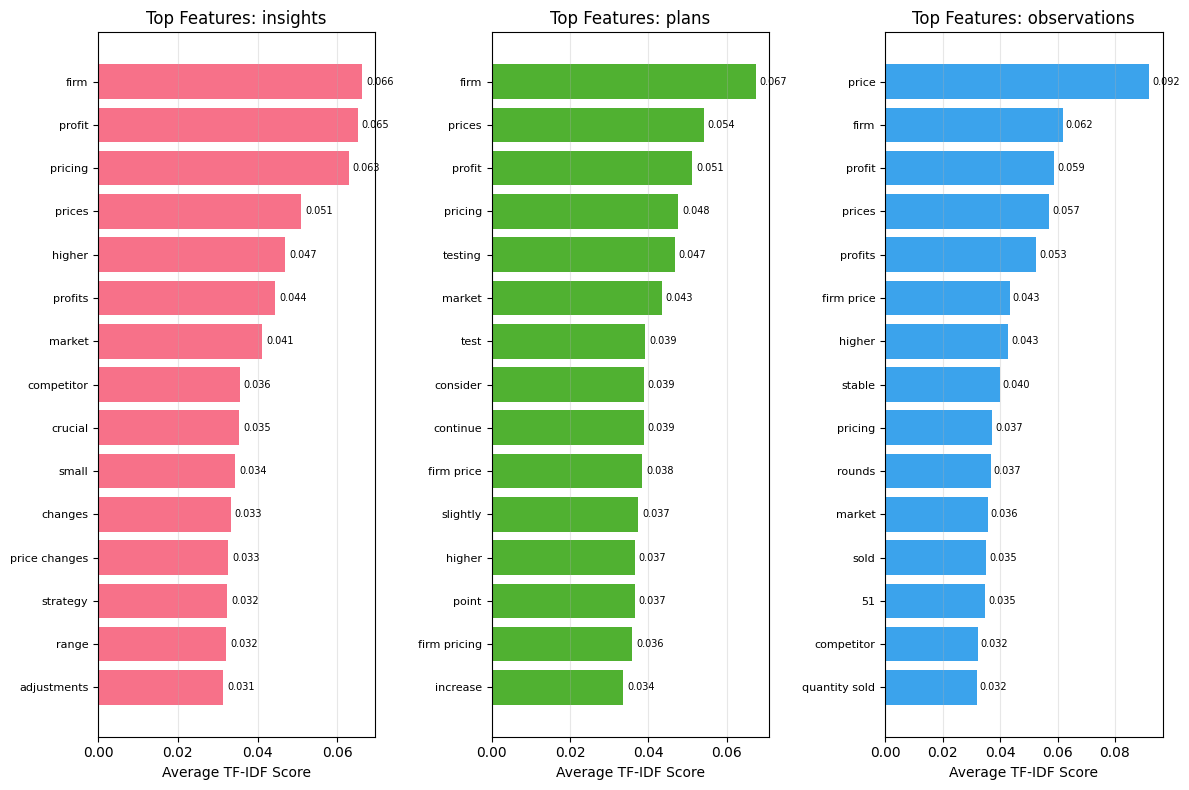

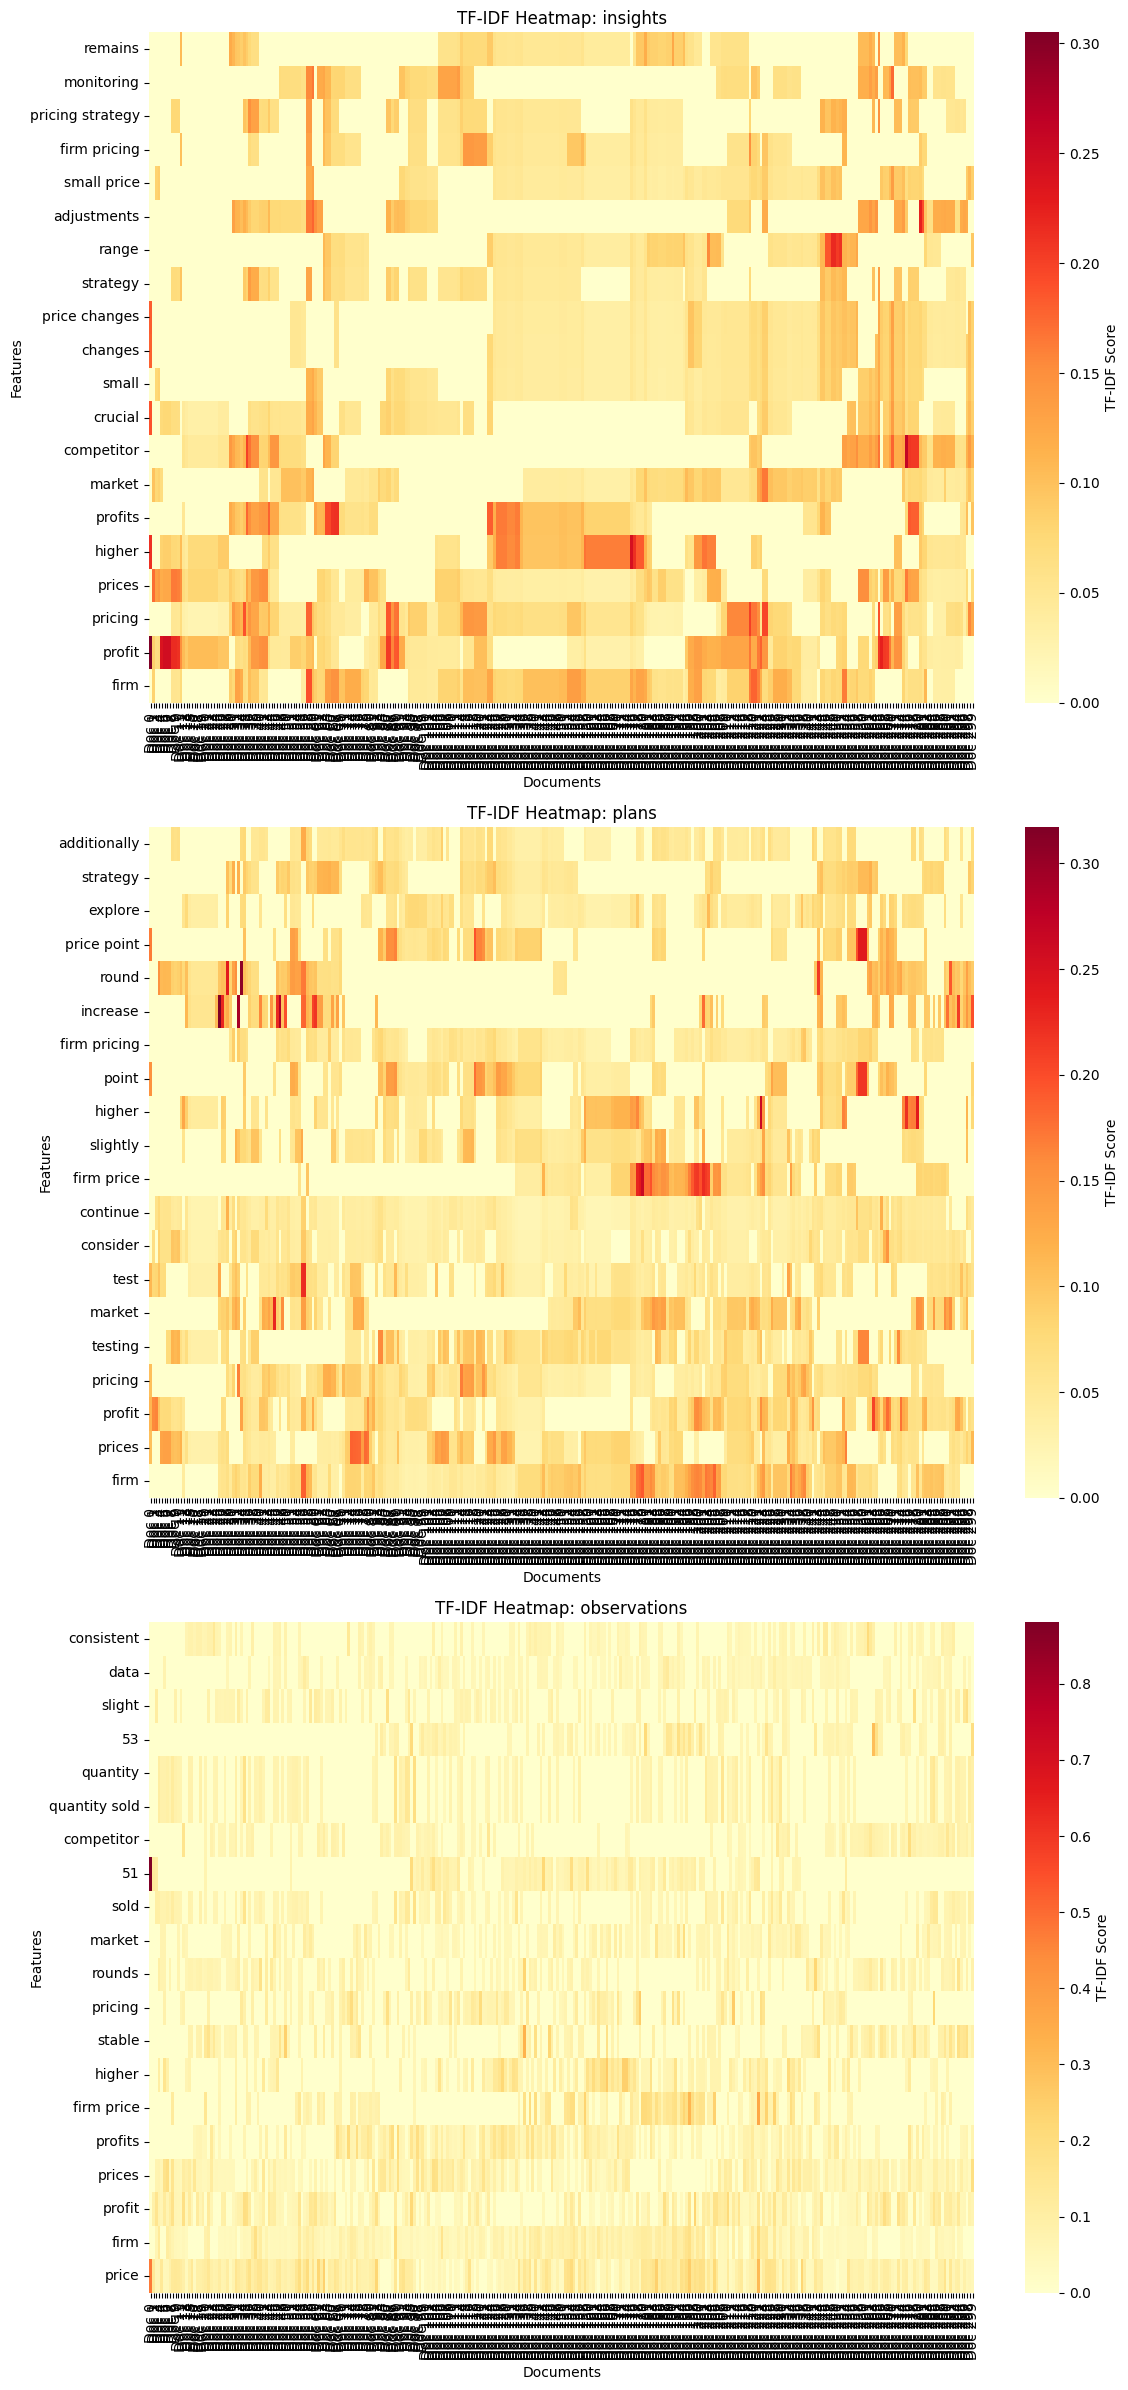

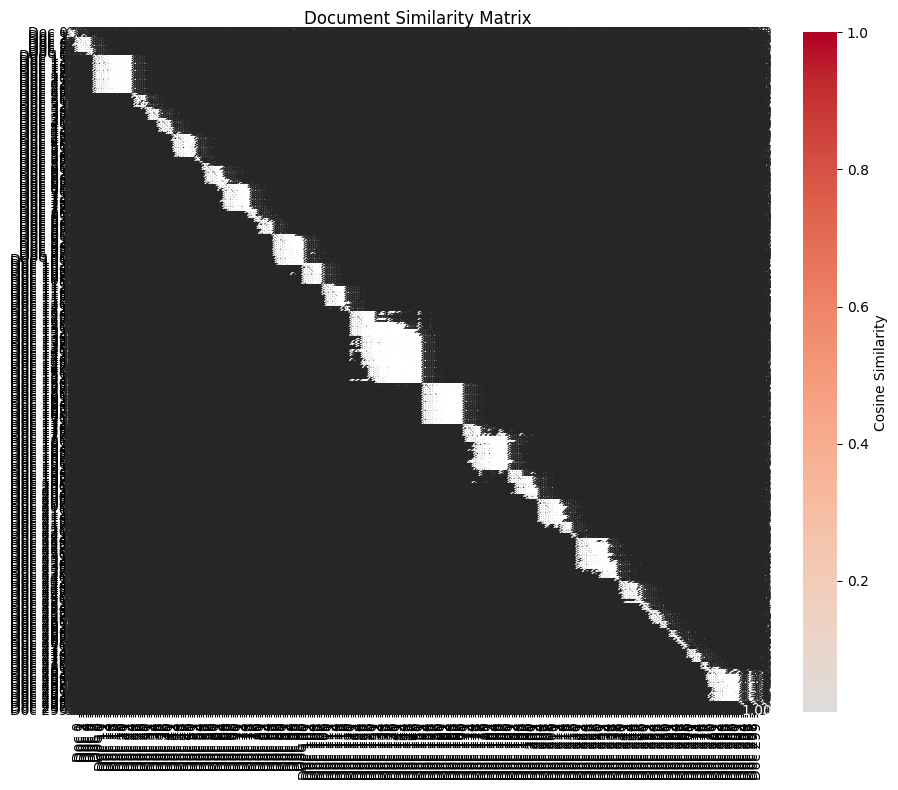

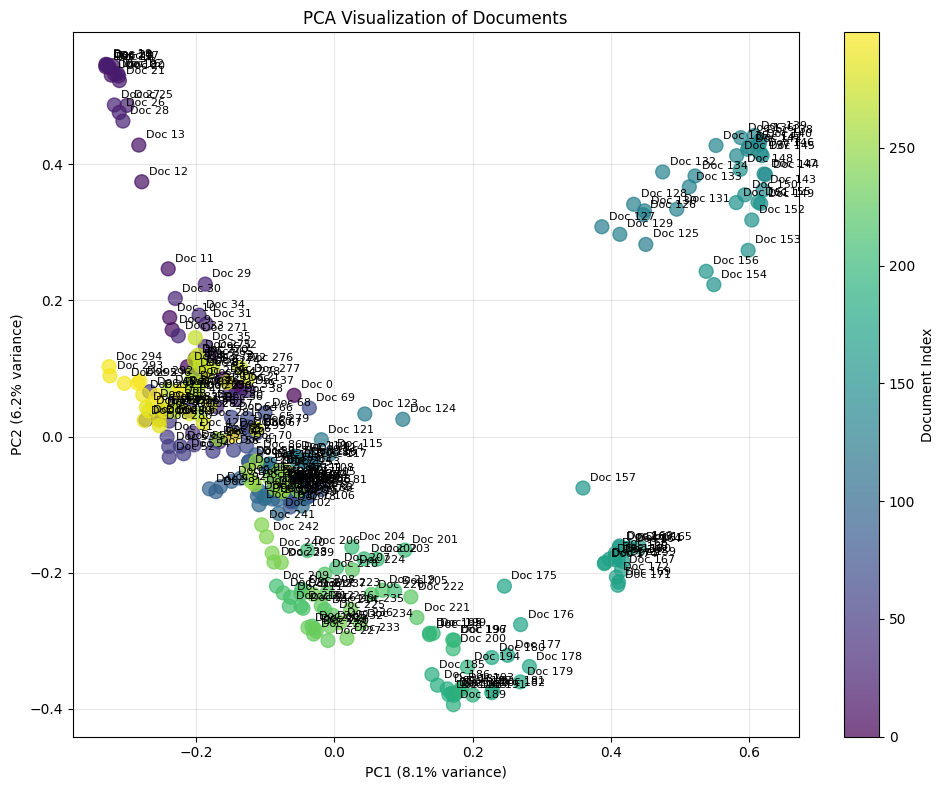

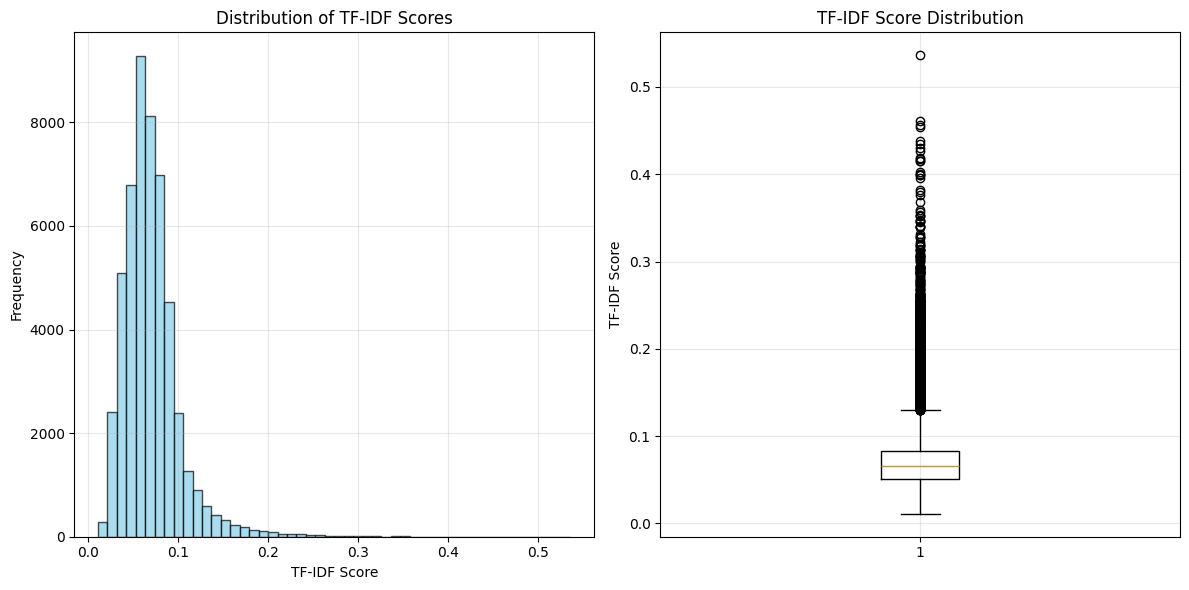

All visualizations created!


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set style
plt.style.use("default")
sns.set_palette("husl")


def plot_top_features_bar(tfidf_results, top_n=15, figsize=(12, 8)):
    """Plot top TF-IDF features as horizontal bar charts"""
    if isinstance(tfidf_results, dict) and "tfidf_matrix" in tfidf_results:
        # Single result (combined or column-aware)
        fig, ax = plt.subplots(figsize=figsize)

        mean_scores = np.array(tfidf_results["tfidf_matrix"].mean(axis=0)).flatten()
        top_indices = mean_scores.argsort()[-top_n:]
        top_features = [tfidf_results["feature_names"][i] for i in top_indices]
        top_scores = mean_scores[top_indices]

        bars = ax.barh(range(len(top_features)), top_scores, color="skyblue")
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features)
        ax.set_xlabel("Average TF-IDF Score")
        ax.set_title("Top TF-IDF Features")
        ax.grid(axis="x", alpha=0.3)

        # Add value labels on bars
        for bar, score in zip(bars, top_scores):
            ax.text(
                bar.get_width() + 0.001,
                bar.get_y() + bar.get_height() / 2,
                f"{score:.3f}",
                va="center",
                fontsize=8,
            )

        plt.tight_layout()

    else:
        # Multiple results (separate columns)
        n_cols = len(tfidf_results)
        fig, axes = plt.subplots(1, n_cols, figsize=(figsize[0], figsize[1]))
        if n_cols == 1:
            axes = [axes]

        for idx, (column, result) in enumerate(tfidf_results.items()):
            ax = axes[idx]

            mean_scores = np.array(result["tfidf_matrix"].mean(axis=0)).flatten()
            top_indices = mean_scores.argsort()[-top_n:]
            top_features = [result["feature_names"][i] for i in top_indices]
            top_scores = mean_scores[top_indices]

            bars = ax.barh(
                range(len(top_features)),
                top_scores,
                color=sns.color_palette("husl", n_cols)[idx],
            )
            ax.set_yticks(range(len(top_features)))
            ax.set_yticklabels(top_features, fontsize=8)
            ax.set_xlabel("Average TF-IDF Score")
            ax.set_title(f"Top Features: {column}")
            ax.grid(axis="x", alpha=0.3)

            # Add value labels
            for bar, score in zip(bars, top_scores):
                ax.text(
                    bar.get_width() + 0.001,
                    bar.get_y() + bar.get_height() / 2,
                    f"{score:.3f}",
                    va="center",
                    fontsize=7,
                )

        plt.tight_layout()

    return fig


def plot_feature_heatmap(tfidf_results, top_n=20, figsize=(12, 8)):
    """Plot heatmap of top features across documents"""
    if isinstance(tfidf_results, dict) and "tfidf_matrix" in tfidf_results:
        # Single result
        tfidf_matrix = tfidf_results["tfidf_matrix"]
        feature_names = tfidf_results["feature_names"]

        # Get top features
        mean_scores = np.array(tfidf_matrix.mean(axis=0)).flatten()
        top_indices = mean_scores.argsort()[-top_n:]

        # Create heatmap data
        heatmap_data = tfidf_matrix[:, top_indices].toarray()
        top_features = [feature_names[i] for i in top_indices]

        plt.figure(figsize=figsize)
        sns.heatmap(
            heatmap_data.T,
            xticklabels=[f"Doc {i}" for i in range(heatmap_data.shape[0])],
            yticklabels=top_features,
            cmap="YlOrRd",
            cbar_kws={"label": "TF-IDF Score"},
        )
        plt.title("TF-IDF Heatmap: Top Features Across Documents")
        plt.xlabel("Documents")
        plt.ylabel("Features")
        plt.tight_layout()

    else:
        # Multiple results - create subplots
        n_cols = len(tfidf_results)
        fig, axes = plt.subplots(n_cols, 1, figsize=(figsize[0], figsize[1] * n_cols))
        if n_cols == 1:
            axes = [axes]

        for idx, (column, result) in enumerate(tfidf_results.items()):
            tfidf_matrix = result["tfidf_matrix"]
            feature_names = result["feature_names"]

            mean_scores = np.array(tfidf_matrix.mean(axis=0)).flatten()
            top_indices = mean_scores.argsort()[-top_n:]

            heatmap_data = tfidf_matrix[:, top_indices].toarray()
            top_features = [feature_names[i] for i in top_indices]

            sns.heatmap(
                heatmap_data.T,
                xticklabels=[f"Doc {i}" for i in range(heatmap_data.shape[0])],
                yticklabels=top_features,
                cmap="YlOrRd",
                ax=axes[idx],
                cbar_kws={"label": "TF-IDF Score"},
            )
            axes[idx].set_title(f"TF-IDF Heatmap: {column}")
            axes[idx].set_xlabel("Documents")
            axes[idx].set_ylabel("Features")

        plt.tight_layout()

    return plt.gcf()


def plot_document_similarity(tfidf_results, figsize=(10, 8)):
    """Plot document similarity heatmap"""
    if isinstance(tfidf_results, dict) and "tfidf_matrix" in tfidf_results:
        tfidf_matrix = tfidf_results["tfidf_matrix"]

        # Calculate cosine similarity
        similarity_matrix = cosine_similarity(tfidf_matrix)

        plt.figure(figsize=figsize)
        sns.heatmap(
            similarity_matrix,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            center=0,
            square=True,
            xticklabels=[f"Doc {i}" for i in range(similarity_matrix.shape[0])],
            yticklabels=[f"Doc {i}" for i in range(similarity_matrix.shape[0])],
            cbar_kws={"label": "Cosine Similarity"},
        )
        plt.title("Document Similarity Matrix")
        plt.tight_layout()

        return plt.gcf()


def plot_pca_visualization(tfidf_results, figsize=(10, 8)):
    """Plot PCA visualization of documents"""
    if isinstance(tfidf_results, dict) and "tfidf_matrix" in tfidf_results:
        tfidf_matrix = tfidf_results["tfidf_matrix"].toarray()

        # Apply PCA
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(tfidf_matrix)

        plt.figure(figsize=figsize)
        plt.scatter(
            pca_result[:, 0],
            pca_result[:, 1],
            alpha=0.7,
            s=100,
            c=range(len(pca_result)),
            cmap="viridis",
        )

        # Add document labels
        for i, (x, y) in enumerate(pca_result):
            plt.annotate(
                f"Doc {i}",
                (x, y),
                xytext=(5, 5),
                textcoords="offset points",
                fontsize=8,
            )

        plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
        plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
        plt.title("PCA Visualization of Documents")
        plt.colorbar(label="Document Index")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        return plt.gcf()


def plot_feature_distribution(tfidf_results, figsize=(12, 6)):
    """Plot distribution of TF-IDF scores"""
    if isinstance(tfidf_results, dict) and "tfidf_matrix" in tfidf_results:
        tfidf_matrix = tfidf_results["tfidf_matrix"]

        # Get all non-zero scores
        scores = tfidf_matrix.data  # Only non-zero values from sparse matrix

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # Histogram
        ax1.hist(scores, bins=50, alpha=0.7, color="skyblue", edgecolor="black")
        ax1.set_xlabel("TF-IDF Score")
        ax1.set_ylabel("Frequency")
        ax1.set_title("Distribution of TF-IDF Scores")
        ax1.grid(True, alpha=0.3)

        # Box plot
        ax2.boxplot(scores, vert=True)
        ax2.set_ylabel("TF-IDF Score")
        ax2.set_title("TF-IDF Score Distribution")
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        return fig


def create_interactive_plots(tfidf_results, top_n=20):
    """Create interactive plots using Plotly"""
    if isinstance(tfidf_results, dict) and "tfidf_matrix" in tfidf_results:
        tfidf_matrix = tfidf_results["tfidf_matrix"]
        feature_names = tfidf_results["feature_names"]

        # Get top features
        mean_scores = np.array(tfidf_matrix.mean(axis=0)).flatten()
        top_indices = mean_scores.argsort()[-top_n:]
        top_features = [feature_names[i] for i in top_indices]
        top_scores = mean_scores[top_indices]

        # Interactive bar chart
        fig_bar = px.bar(
            x=top_scores,
            y=top_features,
            orientation="h",
            title="Top TF-IDF Features (Interactive)",
            labels={"x": "Average TF-IDF Score", "y": "Features"},
        )
        fig_bar.update_layout(height=600)

        # Interactive heatmap
        heatmap_data = tfidf_matrix[:, top_indices].toarray()
        fig_heatmap = px.imshow(
            heatmap_data.T,
            x=[f"Doc {i}" for i in range(heatmap_data.shape[0])],
            y=top_features,
            color_continuous_scale="Viridis",
            title="TF-IDF Heatmap (Interactive)",
        )

        return fig_bar, fig_heatmap

    else:
        # Multiple results
        fig = make_subplots(
            rows=1,
            cols=len(tfidf_results),
            subplot_titles=list(tfidf_results.keys()),
            horizontal_spacing=0.1,
        )

        for idx, (column, result) in enumerate(tfidf_results.items()):
            mean_scores = np.array(result["tfidf_matrix"].mean(axis=0)).flatten()
            top_indices = mean_scores.argsort()[-top_n:]
            top_features = [result["feature_names"][i] for i in top_indices]
            top_scores = mean_scores[top_indices]

            fig.add_trace(
                go.Bar(
                    x=top_scores,
                    y=top_features,
                    orientation="h",
                    name=column,
                    showlegend=False,
                ),
                row=1,
                col=idx + 1,
            )

        fig.update_layout(title="Top TF-IDF Features by Column", height=600)

        return fig


# Example usage with your results:
# Assuming you have run the TF-IDF code and have results

print("Creating TF-IDF visualizations...")

# Plot top features
fig1 = plot_top_features_bar(separate_results, top_n=15)
plt.show()

# Plot feature heatmap
fig2 = plot_feature_heatmap(separate_results, top_n=20)
plt.show()

# Plot document similarity (for combined results)
fig3 = plot_document_similarity(combined_results)
plt.show()

# Plot PCA visualization
fig4 = plot_pca_visualization(combined_results)
plt.show()

# Plot feature distribution
fig5 = plot_feature_distribution(combined_results)
plt.show()

# Create interactive plots
try:
    fig_interactive_bar, fig_interactive_heatmap = create_interactive_plots(
        combined_results
    )
    fig_interactive_bar.show()
    fig_interactive_heatmap.show()
except ImportError:
    print("Plotly not available for interactive plots")

print("All visualizations created!")